In [1]:
import cv2 
import numpy as np

In [2]:
def show_cv2_image(img, figsize=(6, 6), title=None, normalize=True, cmap=None):
    """
    Display an OpenCV image (BGR / BGRA / grayscale) inside a Jupyter notebook.

    Args:
        img: numpy.ndarray from cv2.imread (H,W,3 BGR) or (H,W) grayscale.
        figsize: tuple for matplotlib figure size.
        title: optional title string.
        normalize: if True, clip floats to [0,1]; uint8 kept as-is.
        cmap: colormap for single-channel images (defaults to 'gray').
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import cv2

    if img is None:
        raise ValueError("img is None")

    im = img.copy()

    # Convert BGR/BGRA -> RGB/RGBA for correct display
    if im.ndim == 3 and im.shape[2] == 3:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    elif im.ndim == 3 and im.shape[2] == 4:
        im = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)

    # Normalize floats to [0,1] for matplotlib if requested
    if normalize and np.issubdtype(im.dtype, np.floating):
        im = np.clip(im, 0.0, 1.0)

    plt.figure(figsize=figsize)
    if im.ndim == 2:
        plt.imshow(im, cmap=cmap or "gray")
    else:
        plt.imshow(im)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

In [28]:
def apply_conic_mirror_warp_warpPolar(img, mask, center=None, radius=None, depth=0.8, unwrap_scale=1.0, border_mode=cv2.BORDER_REFLECT):
    """
    Warp `img` inside `mask` using cv2.warpPolar to do the heavy lifting:
    - unwrap the circular region to polar coordinates (rho,theta)
    - apply a 1D radial remap in polar space (the mirror / conic radial warp)
    - reproject back to Cartesian using warpPolar with WARP_INVERSE_MAP

    Args:
        img: HxW(x3) BGR image (numpy).
        mask: single-channel uint8 mask same HxW where non-zero indicates region to warp.
        center: (x,y) center of the circle in pixel coords. If None, image center is used.
        radius: radius in pixels. If None, computed as min(h,w)/4.
        depth: controls strength of the radial remap (larger -> stronger).
        unwrap_scale: downsample factor for unwrap width/height to speed processing (1.0 = full).
        border_mode: cv2 remap border mode.
    Returns:
        warped: image with same dtype as input (warped inside mask, original outside).
    """
    import numpy as _np
    import cv2

    if img is None:
        raise ValueError("img is None")

    h, w = img.shape[:2]
    if center is None:
        cx = w / 2.0
        cy = h / 2.0
    else:
        cx, cy = float(center[0]), float(center[1])

    if radius is None:
        radius = min(h, w) / 4.0

    # unwrap size: rows = radius pixels (rho), cols = circumference ~ 2*pi*radius
    unwrap_h = max(2, int(_np.round(radius * unwrap_scale)))
    unwrap_w = max(4, int(_np.round((2.0 * _np.pi * radius) * unwrap_scale)))

    # create polar (unwrapped) image from the circular region
    # flags: WARP_POLAR_LINEAR maps Cartesian->Polar; result shape = (unwrap_h, unwrap_w)
    polar = cv2.warpPolar(img, (unwrap_w, unwrap_h), (cx, cy), radius, cv2.WARP_POLAR_LINEAR)

    # Build radial remap mapping (1D). For each rho in [0, unwrap_h-1] compute new rho' (source row)
    # Convert rho->r in pixels (0..radius) then apply mirror-like formula s = f * tan(2*atan(r/f))
    eps = 1e-8
    f = float(radius) / max(depth, eps)  # focal-length-like control
    # rho indices -> radius in pixels
    r_vals = _np.linspace(0.0, radius, unwrap_h).astype(_np.float32)
    r_over_f = r_vals / (f + eps)
    two_atan = 2.0 * _np.arctan(r_over_f)
    s = f * _np.tan(two_atan)
    s = _np.nan_to_num(s, nan=radius, posinf=radius, neginf=0.0)
    # clamp to [0, radius]
    s = _np.clip(s, 0.0, radius)
    # convert back to source row indices in polar image
    src_r = (s / radius) * (unwrap_h - 1)
    src_r = src_r.astype(_np.float32)

    # build remap grids to remap polar -> warped_polar
    # for each column (theta) sampling the same src_r rows
    map_x = _np.tile(_np.arange(unwrap_w, dtype=_np.float32)[None, :], (unwrap_h, 1))  # cols unchanged
    map_y = _np.tile(src_r[:, None], (1, unwrap_w))  # rows remapped by radial mapping

    # remap polar image rows according to src_r (interpolated)
    warped_polar = cv2.remap(polar, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=border_mode)

    # reproject warped_polar back to Cartesian using inverse warpPolar
    # flags: WARP_POLAR_LINEAR | WARP_INVERSE_MAP converts Polar->Cartesian using content from warped_polar
    warped_cart = cv2.warpPolar(warped_polar, (w, h), (cx, cy), radius, cv2.WARP_POLAR_LINEAR | cv2.WARP_INVERSE_MAP)

    # combine: outside mask keep original pixels
    out = img.copy()
    mask_bool = (mask > 0)
    if mask_bool.dtype != _np.bool_:
        mask_bool = mask_bool.astype(_np.bool_)
    if warped_cart.ndim == 3:
        for c in range(img.shape[2]):
            out[..., c][mask_bool] = warped_cart[..., c][mask_bool]
    else:
        out[mask_bool] = warped_cart[mask_bool]

    return out
    return warped

In [44]:
img = cv2.imread("input2.png")
mask = np.zeros(img.shape[:2], dtype="uint8")
max_radius = 100
cv2.circle(mask, (img.shape[1]//2, img.shape[0]//2), max_radius, 255, -1)



array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

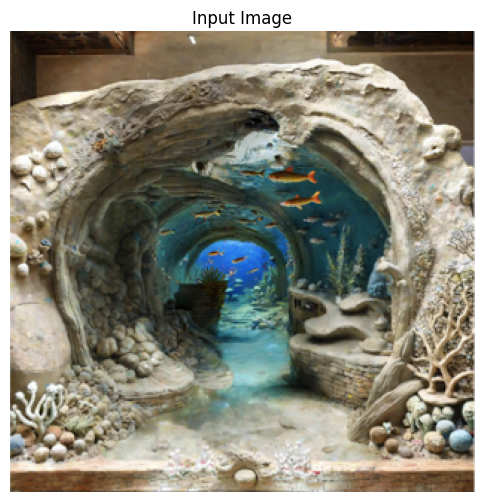

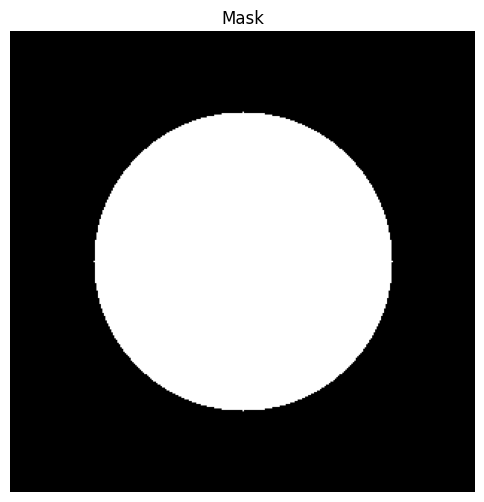

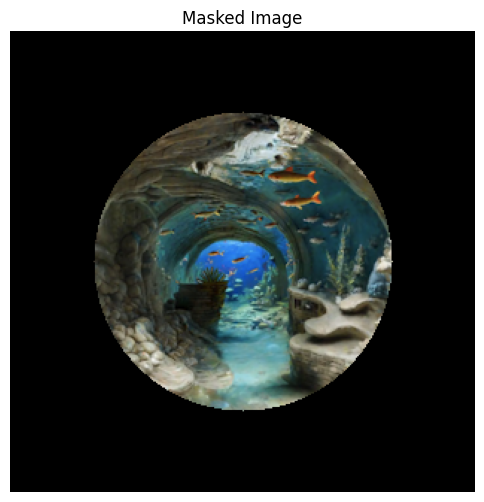

In [45]:
show_cv2_image(img, title="Input Image")
show_cv2_image(mask, title="Mask", cmap="gray")
masked_img = np.zeros_like(img)
masked_img[mask>0] = img[mask>0]

show_cv2_image(masked_img, title="Masked Image")

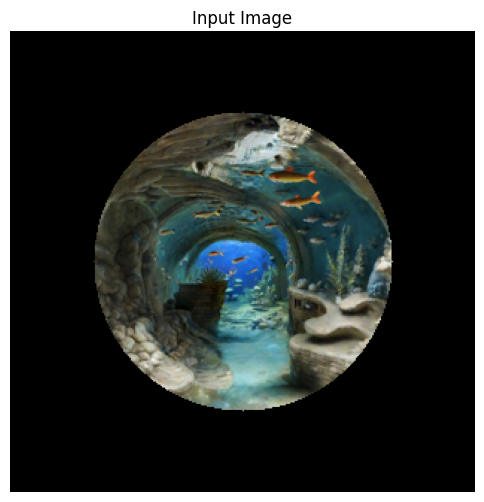

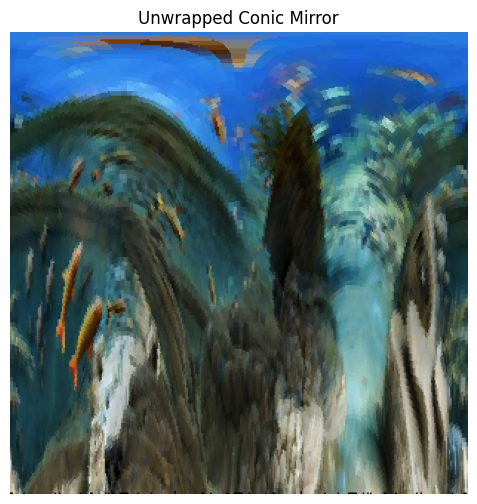

In [46]:
import cv2
import numpy as np


h, w = masked_img.shape[:2]
center = (w // 2, h // 2)

unwrap_height = max_radius
unwrap_width = 2 * np.pi * max_radius

unwrap = cv2.warpPolar(masked_img, (int(w), int(h)), center, max_radius, cv2.WARP_POLAR_LINEAR)
unwrap = cv2.rotate(unwrap, cv2.ROTATE_90_CLOCKWISE)
show_cv2_image(masked_img, title="Input Image")
show_cv2_image(unwrap, title="Unwrapped Conic Mirror")

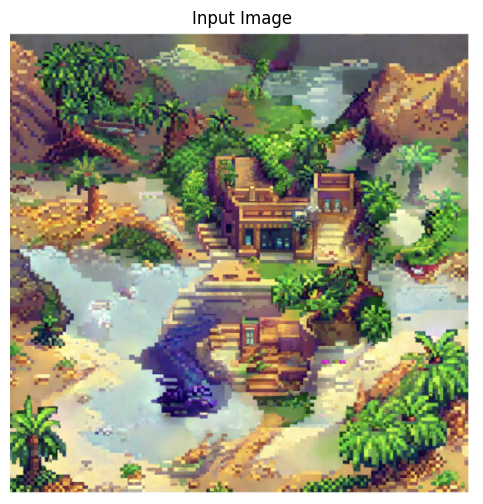

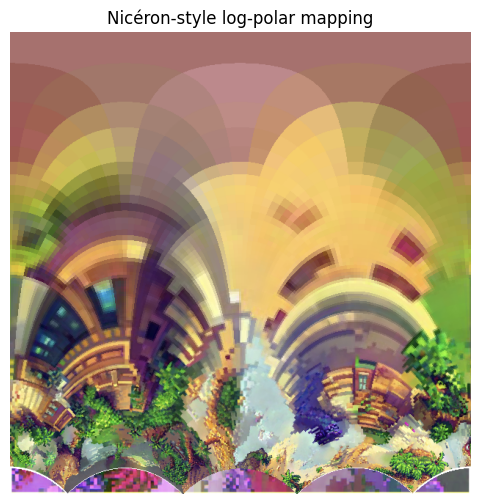

In [56]:
import cv2
import numpy as np

img = cv2.imread('niceron.png')
h, w = img.shape[:2]
cx, cy = w // 2, h // 2
radius = min(cx, cy)

log_base = 1.05  # controls the degree of distortion
max_radius = np.sqrt((cx ** 2) + (cy ** 2))

# apply Nicéron-style log-polar mapping
mapped = cv2.warpPolar(
    img,
    (w, h),
    (cx, cy),
    max_radius,
    cv2.WARP_POLAR_LOG
)

# rotate so it's correctly oriented
mapped = cv2.rotate(mapped, cv2.ROTATE_90_CLOCKWISE)
show_cv2_image(img, title="Input Image")
show_cv2_image(mapped, title="Nicéron-style log-polar mapping")